In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./data/protein_data.csv')
data.head()

,sequence,classification
0,MGAFLDKPKMEKHNAQGQGNGLRYGLSSMQGWRVEMEDAHTAVIGL...,HYDROLASE
1,KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTF...,HYDROLASE
2,IVGGYTCQENSVPYQVSLNSGYHFCGGSLINDQWVVSAAHCYKSRI...,HYDROLASE
3,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,HYDROLASE
4,ELIRVAILWHEMWHEGLEEASRLYFGERNVKGMFEVLEPLHAMMER...,TRANSFERASE


In [3]:
X = data['sequence']
y = data['classification']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
class_names = le.classes_
n_classes = len(class_names)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [4]:
n_classes

2

In [5]:
class_names

array(['HYDROLASE', 'TRANSFERASE'], dtype=object)

In [6]:
avg_char_len = X_train.str.len().mean()
print(f"Average character length: {avg_char_len:.2f}")

Average character length: 313.54


In [7]:
import torch

aa_to_idx = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5,
    'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
    'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15,
    'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20,
    'B': 0, 'Z': 0, 'U': 0, 'O': 0, 'X': 0
}

def encode_sequence(seq, max_len=250):
    seq = str(seq).strip().upper()
    encoded = [aa_to_idx.get(aa, 0) for aa in seq]  # map or 0 if unknown
    if len(encoded) < max_len:
        encoded += [0] * (max_len - len(encoded))  # zero padding
    else:
        encoded = encoded[:max_len]  # truncate if longer
    return torch.tensor(encoded, dtype=torch.long)

In [8]:
print(X_train.iloc[0])
embedding = torch.nn.Embedding(num_embeddings=21, embedding_dim=128, padding_idx=0)
embedding(encode_sequence(X_train.iloc[0]))

MREKLFWILKKYGVSDHIAKAFLEIPREEFLTKSYPLSYVYEDIVLVSYDDGEEYSTSSQPSLMALFMEWVGLDKGMRVLEIGGGTGYNAAVMSRVVGEKGLVVSVEYSRKICEIAKRNVERLGIENVIFVCGDGYYGVPEFSPYDVIFVTVGVDEVPETWFTQLKEGGRVIVPINLKLSRRQPAFLFKKKDPYLVGNYKLETRFITAGGNLGNLLERNRKLLREFPFNREILLVRSHIFVELVDLLTRRLTEIDGTFYYAGPNGVVEFLDDRMRIYGDAPEIENLLTQWESCGYRSFEYLMLHVGYNAFSHISCSI


tensor([[-3.1076, -0.4728, -0.3224,  ...,  0.3513,  1.0129, -2.5773],
        [-0.1652, -0.5367,  1.4301,  ..., -0.0149, -1.5929, -0.5480],
        [ 1.8538,  0.3886,  0.0154,  ..., -0.1027, -2.0763, -1.6396],
        ...,
        [ 0.2448,  0.2652,  0.9244,  ..., -0.4954, -0.0308,  0.4363],
        [-0.1652, -0.5367,  1.4301,  ..., -0.0149, -1.5929, -0.5480],
        [-0.1652, -0.5367,  1.4301,  ..., -0.0149, -1.5929, -0.5480]],
       grad_fn=<EmbeddingBackward0>)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        seq = pd.Series(self.X).iloc[idx]
        label = pd.Series(self.y).iloc[idx]
        encoded_seq = encode_sequence(seq)
        return encoded_seq, torch.tensor(label, dtype=torch.long)

In [10]:
train_dataset = ProteinDataset(X_train, y_train)
val_dataset   = ProteinDataset(X_val, y_val)
test_dataset  = ProteinDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
import time
import torch
import torch.nn as nn
import torch.optim as optim

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_classes, pad_idx=0):
        super(BiLSTMClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.bilstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )
        
        self.fc1 = nn.Linear(hidden_dim * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, n_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x)                   
        output, (h, c) = self.bilstm(x)         
        h = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)
        x = self.relu(self.fc1(h))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc_out(x)
        return x

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

def train_model(model, train_loader, val_loader, n_epochs=20, lr=1e-3, patience=3):
    global history
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    patience_counter = 0
    best_model_wts = None

    for epoch in range(n_epochs):
        epoch_start = time.time()
        
        # --- Train ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_acc = correct / total
        train_loss /= total

        # --- Validation ---
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)

                val_loss += loss.item() * X.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_acc = correct / total
        val_loss /= total

        # --- Save history ---
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        epoch_time = time.time() - epoch_start

        print(f"Epoch {epoch+1}: "
              f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"Val loss={val_loss:.4f}, acc={val_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

        # --- Early Stopping ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                if best_model_wts is not None:
                    model.load_state_dict(best_model_wts)
                break

    return model

In [12]:
vocab_size = 21
embedding_dim = 128
hidden_dim = 128

model = BiLSTMClassifier(vocab_size, embedding_dim, hidden_dim, n_classes)
trained_model = train_model(model, train_loader, val_loader, n_epochs=20, lr=1e-3, patience=3)

Epoch 1: Train loss=0.6504, acc=0.6117 | Val loss=0.6199, acc=0.6517 | Time: 2.81s
Epoch 2: Train loss=0.5898, acc=0.6697 | Val loss=0.5770, acc=0.6841 | Time: 2.32s
Epoch 3: Train loss=0.5239, acc=0.7253 | Val loss=0.5573, acc=0.7173 | Time: 2.31s
Epoch 4: Train loss=0.4465, acc=0.7808 | Val loss=0.5390, acc=0.7380 | Time: 2.31s
Epoch 5: Train loss=0.3832, acc=0.8210 | Val loss=0.5944, acc=0.7469 | Time: 2.33s
Epoch 6: Train loss=0.3027, acc=0.8654 | Val loss=0.5856, acc=0.7697 | Time: 2.30s
Epoch 7: Train loss=0.2371, acc=0.8924 | Val loss=0.6868, acc=0.7616 | Time: 2.29s
Early stopping triggered.


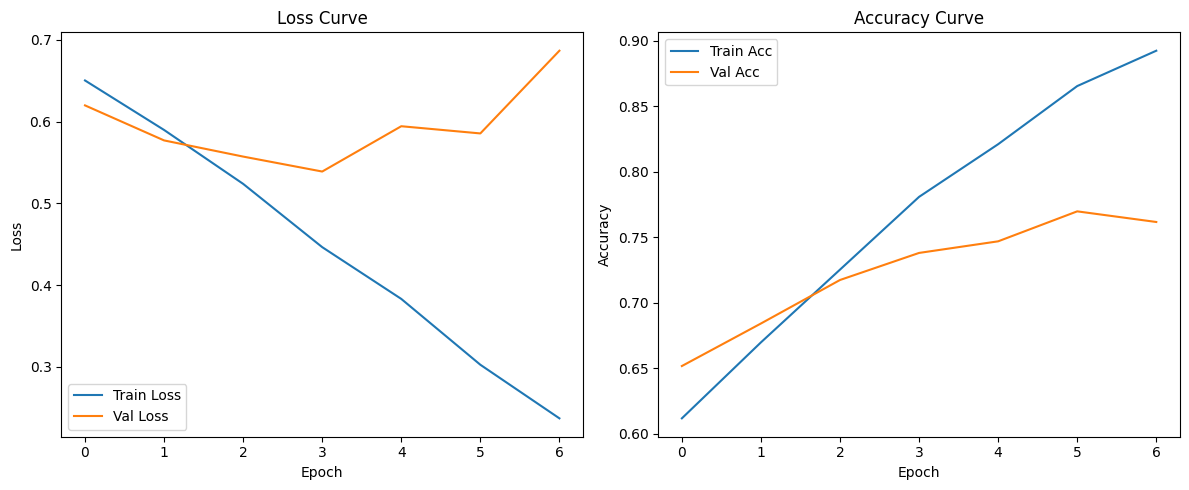

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Loss subplot ---
axes[0].plot(history["train_loss"], label="Train Loss")
axes[0].plot(history["val_loss"], label="Val Loss")
axes[0].set_title("Loss Curve")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# --- Accuracy subplot ---
axes[1].plot(history["train_acc"], label="Train Acc")
axes[1].plot(history["val_acc"], label="Val Acc")
axes[1].set_title("Accuracy Curve")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


In [14]:
import torch
import time

def get_predictions(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return all_preds, all_labels

y_pred, y_true = get_predictions(trained_model, test_loader)

In [15]:
y_true[:10]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 0]

In [16]:
y_pred[:10]

[1, 0, 1, 1, 1, 0, 1, 0, 0, 1]

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [18]:
accuracy_score(y_true, y_pred)

0.7561263655152052

In [19]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1683
           1       0.77      0.73      0.75      1704

    accuracy                           0.76      3387
   macro avg       0.76      0.76      0.76      3387
weighted avg       0.76      0.76      0.76      3387



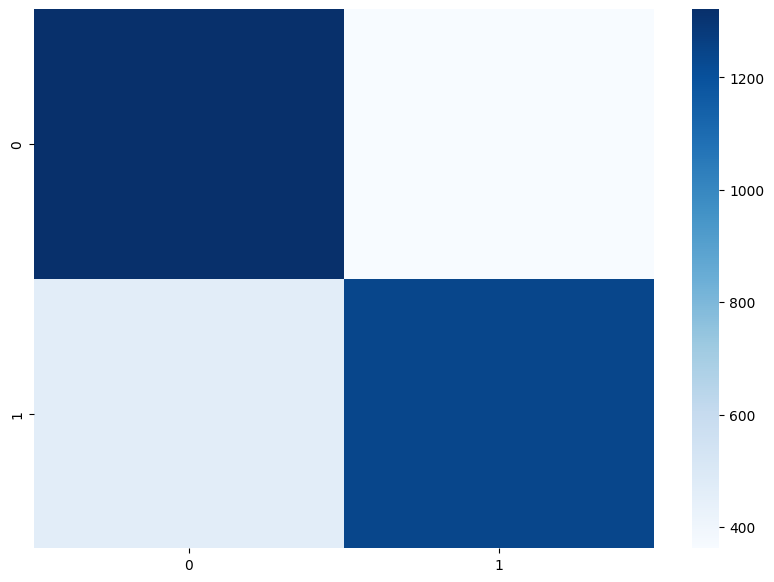

In [20]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap='Blues');

In [21]:
torch.save(model.state_dict(), "./models/bilstm_model_weights.pth")

In [22]:
torch.save(model, "./models/bilstm_model_full.pth")

In [23]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("./models/bilstm_model_full.pth", map_location=device, weights_only=False)
model.to(device)
model.eval()

BiLSTMClassifier(
  (embedding): Embedding(21, 128, padding_idx=0)
  (bilstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [25]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7561
Precision: 0.7571
Recall: 0.7561
F1 Score: 0.7560
